## Load processed data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yaml
import numpy as np
import torch
from collections import Counter
from torch import nn
from torchtext import data
from matplotlib import pyplot as plt
import seaborn as sns
import torch.nn.functional as F
%matplotlib inline
import copy
import argparse
from helper import data_generator
import sys; sys.argv=['']; del sys
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
file = 'args/sst_attn_all.yaml'
# file = 'args/IMDB_rnn.yaml'
# file ='args/mr_rnn.yaml'
with open(file) as f:
    args = yaml.load(f, Loader=yaml.Loader)
    parser = argparse.ArgumentParser(description='attention')
    config = parser.parse_args()
    for k, v in args['common'].items():
        setattr(config, k, v)

In [3]:
import pickle
with open(config.dic_path, 'rb') as f:
    vocab, word2id, id2word = pickle.load(f)

In [4]:
# config.batch_size = 512#for mr
# config.batch_size = 256#for imdb
config.batch_size = 1024#for sst

In [5]:
train_dg = data_generator(config, config.train_path)#training data
dev_dg = data_generator(config, config.dev_path, False)#dev data
test_dg = data_generator(config, config.test_path, False)#test data

## Train a model

In [8]:
from torch.nn import utils as nn_utils
import torch
from torch import optim
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.init as init
from self_defined_gru_no_combination import GRU as MVM_G
from self_defined_lstm_no_combination import LSTM as MVM_L
from self_defined_rnn_no_combination import RNN as MVM_E
from self_defined_gru_linear import GRU as MVMA_G
from self_defined_lstm_linear import LSTM as MVMA_L
from self_defined_rnn_linear import RNN as MVMA_E


# from dynamic_lstm import dynamicLSTM
# from dynamic_gru import dynamicGRU
# from dynamic_rnn import dynamicRNN
from torch.nn import TransformerEncoder, TransformerEncoderLayer  

In [9]:
import math
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000, trainable=False):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        if trainable:
            pe = nn.Parameter(torch.randn(max_len, d_model).uniform_(-0.1, 0.1))
        else:
            pe = torch.zeros(max_len, d_model)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0).transpose(0, 1).to(device)
        #self.register_buffer('pe', pe)
        #print(pe.shape)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        #print(self.pe[:x.size(0), :].shape)
        return self.dropout(x)
def length_to_mask(length, max_len=None, dtype=None):
    """length: B.
    return B x max_len.
    If max_len is None, then max of length will be used.
    """
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask

In [11]:
class SimpleClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, label_dim=1, cell_type='MVMA_G'):
        super(SimpleClassifier, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        #self.embeddings.weight.data.uniform_(-0.05, 0.05)
        self.embeddings.weight.data.uniform_(-0.1, 0.1)
        self.dropout = nn.Dropout(0.5)
        encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=5, 
                                                dim_feedforward=hidden_dim, dropout=0.1)
        

        self.affine = nn.Linear(embed_dim, hidden_dim)
        self.softmax = nn.Softmax(dim=-1)
        self.scale = scale
        
        self.sigmoid = nn.Sigmoid()
        if cell_type == 'MVMA_E':
            self.encoder = MVMA_E(embed_dim, hidden_dim, 
                          bidirectional=False)
        elif cell_type == 'MVMA_G':
            self.encoder = MVMA_G(embed_dim, hidden_dim, 
                          bidirectional=False)
        elif cell_type == 'MVMA_L':
            self.encoder = MVMA_L(embed_dim, hidden_dim, 
                          bidirectional=False)
        elif cell_type == 'transformer':
            self.pos_encoder = PositionalEncoding(embed_dim, trainable=False)
            self.encoder = TransformerEncoder(encoder_layer, 2)
#         self.rnn = RNN(embed_dim, hidden_dim, 
#                       bidirectional=False)
        self.cell_type = cell_type
        self.linear = nn.Linear(embed_dim, hidden_dim)
        self.label_dim = label_dim

        self.decoder = nn.Linear(hidden_dim, label_dim, bias=False)

    # batch_size * sent_l * dim
    def forward(self, seq_ids, seq_lengths=None):
        '''
        Args:
            seq_ids: word indexes, batch_size, max_len, Long Tensor
            seq_lengths: lengths of sentences, batch_size, Long Tensor
        attention:
            score = v h
            att = softmax(score)
        '''
        
        seq_embs = self.embeddings(seq_ids)
        seq_embs = self.dropout(seq_embs)
        #print(seq_embs.shape)
        batch_size, max_len, hidden_dim = seq_embs.size()
        # batch * max_len * hidden_states
        #hidden_vecs = self.affine(seq_embs)
        if self.cell_type != 'transformer':
            hidden_vecs, final_vec = self.encoder(seq_embs, seq_lengths)
        else:
            seq_embs = self.pos_encoder(seq_embs.transpose(0, 1))
            src_key_mask = ~length_to_mask(seq_lengths)
            hidden_vecs = self.encoder(seq_embs, src_key_padding_mask=src_key_mask.to(device))
            hidden_vecs = hidden_vecs.transpose(0, 1)
            final_vec = hidden_vecs.mean(1)
            
        #final_vec = self.linear(seq_embs)
        final_vec = self.dropout(final_vec)
        senti_scores = self.decoder(final_vec)
        #multi class
        if self.label_dim == 1:
            probs = self.sigmoid(senti_scores)
        else:
            probs = self.softmax(senti_scores)
            logits = torch.log(probs + 0.000000000001)
            return logits, senti_scores
        return probs, senti_scores

In [12]:
# class SimpleAttnClassifier(nn.Module):
#     def __init__(self, vocab_size, embed_dim, hidden_dim, label_dim=1, cell_type='elman'):
#         super(SimpleAttnClassifier, self).__init__()
        
#         self.embeddings = nn.Embedding(vocab_size, embed_dim)
#         #self.embeddings.weight.data.uniform_(-0.05, 0.05)
#         self.dropout = nn.Dropout(0.5)

#         self.affine = nn.Linear(embed_dim, hidden_dim)
#         encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=2, 
#                                                 dim_feedforward=hidden_dim, dropout=0.1)
#         self.softmax = nn.Softmax(dim=-1)
#         self.scale = 10#np.sqrt(hidden_dim)
        
#         self.sigmoid = nn.Sigmoid()
#         if cell_type == 'elman':
#             self.rnn = RNN(embed_dim, hidden_dim//2, 
#                           bidirectional=True)
#         elif cell_type == 'gru':
#             self.rnn = GRU(embed_dim, hidden_dim//2, 
#                           bidirectional=True)
#         elif cell_type == 'lstm':
#             self.rnn = LSTM(embed_dim, hidden_dim//2, 
#                           bidirectional=True)
#         elif cell_type == 'transformer':
#             self.pos_encoder = PositionalEncoding(embed_dim, trainable=False)
#             self.encoder = TransformerEncoder(encoder_layer, 1)
#         self.cell_type = cell_type
#         self.linear = nn.Linear(embed_dim, hidden_dim)
#         self.label_dim = label_dim
#         self.V = nn.Parameter(torch.randn(hidden_dim, 1))
#         self.decoder = nn.Linear(hidden_dim, label_dim, bias=False)

#     # batch_size * sent_l * dim
#     def forward(self, seq_ids, seq_lengths=None):
#         '''
#         Args:
#             seq_ids: word indexes, batch_size, max_len, Long Tensor
#             seq_lengths: lengths of sentences, batch_size, Long Tensor
#         attention:
#             score = v h
#             att = softmax(score)
#         '''
        
#         seq_embs = self.embeddings(seq_ids)
#         seq_embs = self.dropout(seq_embs)
#         #print(seq_embs.shape)
#         batch_size, max_len, hidden_dim = seq_embs.size()
#         # batch * max_len * hidden_states
#         if self.cell_type != 'transformer':
#             hidden_vecs, final_vec = self.rnn(seq_embs, seq_lengths)
#         else:
#             seq_embs = self.pos_encoder(seq_embs.transpose(0, 1))
#             src_key_mask = ~length_to_mask(seq_lengths)
#             hidden_vecs = self.encoder(seq_embs, src_key_padding_mask=src_key_mask.to(device))
#             hidden_vecs = hidden_vecs.transpose(0, 1)
        
#         inter_out = hidden_vecs
#         #batch * max_len
#         scores = torch.matmul(inter_out, self.V).squeeze(-1)

#         #scores = torch.matmul(inter_out, self.decoder.weight.transpose(0, 1)).squeeze(-1)
#         scores = scores/self.scale#we found this is very important to handle variances of scores
        
#         #Mask the padding values
#         mask = torch.zeros(batch_size, max_len)
#         for i in range(batch_size):
#             mask[i, seq_lengths[i]:] = 1
#         scores = scores.masked_fill(mask.to(device).bool(), -np.inf)
#         #print(scores)
#         #Softmax, batch_size*1*max_len
#         attn = self.softmax(scores).unsqueeze(1)
#         #weighted sum, batch_size*hidden_dim
#         final_vec = torch.bmm(attn, hidden_vecs).squeeze(1)
        
#         #final_vec = self.linear(seq_embs)
#         final_vec = self.dropout(final_vec)
#         senti_scores = self.decoder(final_vec)
#         #multi class
#         if self.label_dim == 1:
#             probs = self.sigmoid(senti_scores)
#         else:
#             probs = self.softmax(senti_scores)
#             logits = torch.log(probs + 0.000000000001)
#             return logits, senti_scores
#         return probs, senti_scores
    
#     def load_vector(self, path, trainable=True):
#         '''
#         Load pre-savedd word embeddings
#         '''
#         with open(path, 'rb') as f:
#             vectors = pickle.load(f)
#             print("Loaded from {} with shape {}".format(path, vectors.shape))
#             #self.word_embed.weight = nn.Parameter(torch.FloatTensor(vectors))
#             np_data = torch.from_numpy(vectors)#/4
#             self.embeddings.weight.data.copy_(np_data)
#             self.embeddings.weight.requires_grad = trainable
#             print('embeddings loaded')

In [13]:
##Evaluation classification
def evaluate_cls(dg, model, binary=True):
    #Make prediction
    model.eval()
    count = 0
    #record the gold and the prediction
    gold_labels = []
    pred_labels = []
    dg.reset_samples()
    while dg.index<dg.data_len:
        sent_ids, label_list, sent_lens = next(dg.get_ids_samples())
        outputs, _ =  model(sent_ids.to(device), sent_lens.to(device))
        if binary:
            preds = (outputs>0.5).squeeze()
            gold_labels += list(label_list.cpu().numpy())
            pred_labels += list(preds.cpu().numpy())
            num = (preds.cpu() == label_list.bool()).sum().cpu().item()
        else:
            preds = outputs.argmax(1)
            num = (label_list==preds.cpu()).sum().item()

        count += num

    accuracy = count*1.0/dg.data_len
    print('Evaluation accuracy:', accuracy)
    return accuracy


#regression
def evaluate_reg(dg, model):
    #Make prediction
    model.eval()
    count = 0
    #record the gold and the prediction
    error = 0
    dg.reset_samples()
    while dg.index<dg.data_len:
        sent_ids, label_list, sent_lens = next(dg.get_ids_samples())
        probs, scores = model(sent_ids.to(device), sent_lens)#.to(device))
        #label_list.apply_(scale_value)
        loss = loss_func(scores.squeeze(), label_list.float().to(device))
        num = len(sent_lens)
        error += loss.item() * num
        count += num

    mse = error/count
    return mse

In [ ]:
# torch.manual_seed(555)
# np.random.seed(555)
hidden_dim = 300
label_dim = 5

loss_func = nn.BCELoss()
if label_dim > 1:
    loss_func = nn.NLLLoss()

valid_accs = []
test_accs = []
for scale in range(5):
    model = SimpleClassifier(config.vocab_size, 300, hidden_dim, label_dim, 'MVMA_L')
    #model.load_vector(config.emb_path, trainable=True)
    
    model = model.to(device)
    ##################################
    ####Weight decay can influence the result, if the value is too large, the model will not converge after iterations
    #optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0.000000)
    #optimizer = optim.Adagrad(model.parameters(), lr=0.5, weight_decay=0.00000, lr_decay=0.001)
    #optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.000001, lr_decay=0.001)

    
    loop_num = int(train_dg.data_len/config.batch_size)+1
    best_model = None
    best_acc = -1
    train_acc = []
    valid_acc = []
    
    for i in range(30):
        print('Epoch:', i)
        print('#'*20)
        
        ##For gru
        #optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=0.00001, lr_decay=0.001)
        #for transformer
        optimizer = optim.Adagrad(model.parameters(), lr=0.002, weight_decay=0.00001, lr_decay=0.001)

        total_loss = 0
        model.train()
        #shuffle the training set given the random seed
        train_dg.shuffle_data()
        #sequential sampling, use all the dataset
        train_dg.reset_samples()
        #model.embeddings.required_grad = config.update_emb
        for j in range(loop_num):
            model.zero_grad()
            # generate dataset
            sent_ids,  label_list, sent_lens = next(train_dg.get_sequential_ids_samples())
            logits, scores = model(sent_ids.to(device), sent_lens.to(device))
            #label_list.apply_(scale_value)
            
            #print(logits.item())
            if label_dim == 1:
                loss = loss_func(logits.squeeze(), label_list.to(device).float())
            else:
                loss = loss_func(logits.squeeze(), label_list.to(device))#.float())#

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(),5)
            optimizer.step()
            if j%20== 0:
                l = loss.cpu().item()
                print('Sample Loss:{:.3f}'.format(l))

        dev_acc = evaluate_cls(dev_dg, model, binary=label_dim==1)
        valid_acc.append(dev_acc)
        if best_acc < dev_acc:
            best_acc = dev_acc
            best_model = copy.deepcopy(model)

    print('Best dev:', best_acc)
    test_acc = evaluate_cls(test_dg, best_model, binary=label_dim==1)
    #Test performance       
    print('Scale', scale, 'Test ACC:', test_acc)
    valid_accs.append(best_acc)
    test_accs.append(test_acc)

    

MVMA-L
Epoch: 0
####################
Sample Loss:1.610
Sample Loss:1.024
Sample Loss:0.927
Sample Loss:0.878
Sample Loss:0.834
Evaluation accuracy: 0.5149082568807339
Epoch: 1
####################
Sample Loss:0.803
Sample Loss:0.711
Sample Loss:0.660
Sample Loss:0.600
Sample Loss:0.588
Evaluation accuracy: 0.7637614678899083
Epoch: 2
####################
Sample Loss:0.498
Sample Loss:0.476
Sample Loss:0.482
Sample Loss:0.450
Sample Loss:0.454
Evaluation accuracy: 0.8119266055045872
Epoch: 3
####################
Sample Loss:0.408
Sample Loss:0.408
Sample Loss:0.342
Sample Loss:0.342
Sample Loss:0.312
Evaluation accuracy: 0.823394495412844
Epoch: 4
####################
Sample Loss:0.328
Sample Loss:0.339
Sample Loss:0.324
Sample Loss:0.335
Sample Loss:0.318
Evaluation accuracy: 0.823394495412844
Epoch: 5
####################
Sample Loss:0.322
Sample Loss:0.294
Sample Loss:0.294
Sample Loss:0.298
Sample Loss:0.274
Evaluation accuracy: 0.819954128440367
Epoch: 6
####################
Sample

In [15]:
for item in valid_accs:
    print(item)

0.8543577981651376
0.8543577981651376
0.8520642201834863


In [16]:
test_accs
for item in test_accs:
    print(item)

0.8583196046128501
0.8506315211422295
0.8489840746842394


In [ ]:
#print('Best dev:', best_acc)
scale = 10
test_acc = evaluate_cls(test_dg, best_model)
#Test performance       
print('Scale', scale, 'Test ACC:', test_acc)

imdb valid 89.0   test 0.8804
mr valid 0.796 test 0.767

In [143]:
# best_model = torch.load("checkpoints/sst_spectral_norm_gru_20210927.pt")
#best_model = torch.load("checkpoints/sst_spectral_norm_elman_20210927.pt")
# best_model = torch.load("checkpoints/sst_spectral_norm_lstm_20210927.pt")

#torch.save(best_model, "checkpoints/imdb_spectral_norm_gru_20210927.pt")

## Examine results from self-defined RNNs

In [30]:
from all_ngram_feature import *

In [38]:
word2id['bad']

88

In [44]:
sent = [29, 88]
gru_phrase_polarity_multi(sent, best_model, hidden_dim=300)

tensor([-0.3225, -0.0042,  0.4190], device='cuda:0')

In [41]:
inputs = torch.LongTensor([sent]).to(device)
length = torch.LongTensor([2])
probs, scores = best_model(inputs, length.to(device))
#_, scores = get_higher_degree_ngram(inputs, best_model, degree=3, hidden_dim=300)
scores

tensor([[ 2.8089, -0.5653, -0.1237]], device='cuda:0', grad_fn=<MmBackward>)

### Elman RNN

In [152]:
best_model.eval()
elman_first_degree_scores = []
elman_second_degree_scores = []
awful = word2id['awful']
amazing = word2id['amazing']
not_ = word2id['not']
very = word2id['very']
sents = [[amazing], [very, amazing], [not_, amazing], 
         [not_, not_, amazing], [awful], [very, awful], [not_, awful], [not_, not_, awful]]
labels = ['amazing', 'very amazing', 'not amazing', 
          'not not amazing', 'awful', 'very awful', 'not awful', 'not not awful']
lengths = [1, 2, 2, 3, 1, 2, 2, 3]

for i, sent in enumerate(sents):
    print(' '.join([id2word[w] for w in sent]))
    inputs = torch.LongTensor([sent]).to(device)
    length = torch.LongTensor([lengths[i]])
    probs, scores = best_model(inputs, length.to(device))
    print('real', scores.item())
    scores = rnn_phrase_polarity_new(sent, best_model, 300)
    print('first-degree approx', scores)
    elman_first_degree_scores.append(scores)
    phi, scores = get_higher_degree_ngram(inputs, best_model, degree=2, hidden_dim=300)
    elman_second_degree_scores.append(scores[:,-1][0].item())
    print('seond degree approx', scores[:,-1][0].item())

amazing
real 1.7740238904953003
first-degree approx 1.7679108381271362
seond degree approx 1.7679108381271362
very amazing
real 3.4417803287506104
first-degree approx 1.865437626838684
seond degree approx 1.6167563199996948
not amazing
real 0.12541809678077698
first-degree approx -1.709215760231018
seond degree approx -1.9143320322036743
not not amazing
real 0.1223953366279602
first-degree approx -0.0673142522573471
seond degree approx 0.03873423859477043
awful
real -1.7218923568725586
first-degree approx -1.6802411079406738
seond degree approx -1.6802411079406738
very awful
real -3.481248617172241
first-degree approx -2.0158090591430664
seond degree approx -1.4931972026824951
not awful
real 0.10105571150779724
first-degree approx 1.882822036743164
seond degree approx 2.3339004516601562
not not awful
real 0.0360625796020031
first-degree approx -0.017644550651311874
seond degree approx -0.25441500544548035


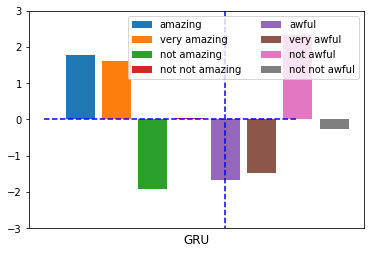

In [154]:
# for i in range(len(elman_first_degree_scores)):
#     plt.bar(i, elman_first_degree_scores[i], label=labels[i])
for i in range(len(elman_second_degree_scores)):
    plt.bar(i, elman_second_degree_scores[i], label=labels[i])
plt.plot([-1,6], [0, 0], 'b', linestyle='--')
plt.plot([4,4], [-6.5, 6.5], 'b', linestyle='--')
ax = plt.gca()
ax.set_title('GRU', y=-0.1)
ax.axes.xaxis.set_visible(False)
plt.ylim(-3, 3)
plt.legend(ncol=2)

## GRU

In [17]:
best_model.eval()
gru_first_degree_scores = []
awful = word2id['awful']
amazing = word2id['amazing']
not_ = word2id['not']
very = word2id['very']
sents = [[amazing], [very, amazing], [not_, amazing], 
         [not_, not_, amazing], [awful], [very, awful], [not_, awful], [not_, not_, awful]]
labels = ['amazing', 'very amazing', 'not amazing', 
          'not not amazing', 'awful', 'very awful', 'not awful', 'not not awful']
lengths = [1, 2, 2, 3, 1, 2, 2, 3]
for i, sent in enumerate(sents):
    print(' '.join([id2word[w] for w in sent]))
    inputs = torch.LongTensor([sent]).to(device)
    length = torch.LongTensor([lengths[i]])
    probs, scores = best_model(inputs, length.to(device))
    print('real', scores.item())
    scores = gru_phrase_polarity_new(sent, best_model, 300)
    print('approx', scores)
    gru_first_degree_scores.append(scores)

amazing
real 9.08558177947998
approx 9.999212265014648
very amazing
real 8.987044334411621
approx 0.08840620517730713
not amazing
real -0.06087500602006912
approx -7.169424057006836
not not amazing
real -0.09008053690195084
approx 0.04791463911533356
awful
real -6.310919284820557
approx -8.080079078674316
very awful
real -4.444940567016602
approx 1.8684308528900146
not awful
real -5.530052661895752
approx 1.4990994930267334
not not awful
real -5.441023826599121
approx 0.4996188282966614


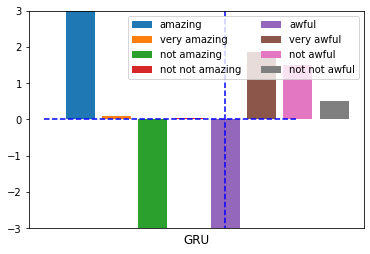

In [18]:
for i in range(len(gru_first_degree_scores)):
    plt.bar(i, gru_first_degree_scores[i], label=labels[i])
plt.plot([-1,6], [0, 0], 'b', linestyle='--')
plt.plot([4,4], [-6.5, 6.5], 'b', linestyle='--')
ax = plt.gca()
ax.set_title('GRU', y=-0.1)
ax.axes.xaxis.set_visible(False)
plt.ylim(-3, 3)
plt.legend(ncol=2)

## LSTM

In [161]:
best_model.eval()
awful = word2id['awful']
amazing = word2id['amazing']
not_ = word2id['not']
very = word2id['very']
lstm_first_degree_scores = []
sents = [[amazing], [very, amazing], [not_, amazing], 
         [not_, not_, amazing], [awful], [very, awful], [not_, awful], [not_, not_, awful]]
labels = ['amazing', 'very amazing', 'not amazing', 
          'not not amazing', 'awful', 'very awful', 'not awful', 'not not awful']
lengths = [1, 2, 2, 3, 1, 2, 2, 3]
for i, sent in enumerate(sents):
    print(' '.join([id2word[w] for w in sent]))
    inputs = torch.LongTensor([sent]).to(device)
    length = torch.LongTensor([lengths[i]])
    probs, scores = model(inputs, length.to(device))
    print('real', scores.item())
    scores = lstm_phrase_polarity_new(sent, model, 300)
    print('approx', scores)
    lstm_first_degree_scores.append(scores)

amazing
real 0.9530318379402161
approx 0.9486384987831116
very amazing
real 3.1096980571746826
approx 2.8145484924316406
not amazing
real -0.467763751745224
approx -1.6512925624847412
not not amazing
real 0.3846995234489441
approx 1.2782796621322632
awful
real -0.9194007515907288
approx -0.9077060222625732
very awful
real -3.0138728618621826
approx -2.71238112449646
not awful
real 0.7023808360099792
approx 1.819990634918213
not not awful
real -0.37374943494796753
approx -1.3033583164215088


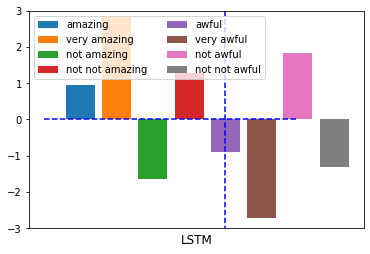

In [162]:
for i in range(len(lstm_first_degree_scores)):
    plt.bar(i, lstm_first_degree_scores[i], label=labels[i])
plt.plot([-1,6], [0, 0], 'b', linestyle='--')
plt.plot([4,4], [-6.5, 6.5], 'b', linestyle='--')
ax = plt.gca()
ax.set_title('LSTM', y=-0.1)
ax.axes.xaxis.set_visible(False)
plt.ylim(-3, 3)
plt.legend(ncol=2)

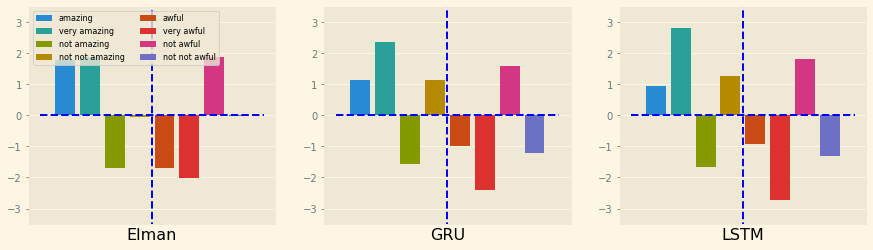

In [175]:
plt.style.use('Solarize_Light2')
plt.figure(figsize=(15, 4))
labels = ['amazing', 'very amazing', 'not amazing', 
          'not not amazing', 'awful', 'very awful', 'not awful', 'not not awful']



# plt.subplot(142)
# for i in range(len(elman_second_degree_scores)):
#     plt.bar(i, elman_second_degree_scores[i], label=labels[i])
# plt.plot([-1,8], [0, 0], 'b', linestyle='--')
# plt.plot([3.5,3.5], [-6.5, 6.5], 'b', linestyle='--')
# ax = plt.gca()
# ax.set_title('Elman (2rd)', y=-0.1)
# # ax.axes.xaxis.set_visible(False)
# ax.axes.xaxis.set_visible(False)
# plt.ylim(-3.5, 3.5)


plt.subplot(132)
for i in range(len(gru_first_degree_scores)):
    plt.bar(i, gru_first_degree_scores[i], label=labels[i])
plt.plot([-1,8], [0, 0], 'b', linestyle='--')
plt.plot([3.5,3.5], [-6.5, 6.5], 'b', linestyle='--')
ax = plt.gca()
ax.set_title('GRU', y=-0.1)
ax.axes.xaxis.set_visible(False)
plt.ylim(-3.5, 3.5)

plt.subplot(133)
for i in range(len(lstm_first_degree_scores)):
    plt.bar(i, lstm_first_degree_scores[i], label=labels[i])
plt.plot([-1,8], [0, 0], 'b', linestyle='--')
plt.plot([3.5,3.5], [-6.5, 6.5], 'b', linestyle='--')
# plt.legend()

ax = plt.gca()
ax.set_title('LSTM', y=-0.1)
ax.axes.xaxis.set_visible(False)
# plt.xticks(ticks=range(0, 5), )
plt.ylim(-3.5, 3.5)


plt.subplot(131)
for i in range(len(elman_first_degree_scores)):
    plt.bar(i, elman_first_degree_scores[i], label=labels[i])
plt.plot([-1,8], [0, 0], 'b', linestyle='--')
plt.plot([3.5,3.5], [-6.5, 6.5], 'b', linestyle='--')
ax = plt.gca()
ax.set_title('Elman', y=-0.1)
ax.axes.xaxis.set_visible(False)
plt.ylim(-3.5, 3.5)
plt.xlabel('Elman (1st-degree)')
plt.legend(loc=2, prop={'size': 8}, ncol=2, bbox_to_anchor=(0, 1.0))
plt.savefig("imgs/negation_intensification_rnn.pdf", bbox_inches='tight', dpi=900)

## Check Approximation

In [19]:
from self_defined_lstm_spectral import LSTM2

In [61]:
def get_errors(rnn_type = 'elman'):
    best_model.eval()
    test_dg.reset_samples()
    errors = []
    while test_dg.index<test_dg.data_len:
        sent_ids,  label_list, sent_lens = next(test_dg.get_sequential_ids_samples())
        sent_ids = sent_ids.to(device)
        preds, scores =  best_model(sent_ids, sent_lens.to(device))

        seq_embs = best_model.embeddings(sent_ids)
        batch_size, max_len, hidden_dim = seq_embs.size()
        ##############gru, elman rnn
        if rnn_type != 'lstm':
            hidden_vecs, final_vecs = best_model.rnn(seq_embs, sent_lens.to(device))
        else:
            lstm2 = LSTM2(300, 300).to(device)
            lstm2.f_cell.linear_hh.weight = best_model.rnn.f_cell.linear_hh.weight
            lstm2.f_cell.weight_ih = best_model.rnn.f_cell.weight_ih
            hidden_vecs, final_vecs, cell_vecs = lstm2(seq_embs, sent_lens.to(device))



        batch_size, max_len, _ = hidden_vecs.shape
        hiddens = torch.zeros_like(hidden_vecs).to(device)
        if rnn_type == 'lstm':
            cells = torch.zeros_like(hidden_vecs).to(device)
            cells[:, 1:] = cell_vecs[:, :-1]
        hiddens[:, 1:] = hidden_vecs[:, :-1]
        approx_hiddens = torch.zeros_like(hiddens)
        #predict next hidden state
        for j in range(max_len):
            x = seq_embs[:, j]
            hidden = hiddens[:, j]

            ####GRU
            if rnn_type == 'gru':
                approx_hiddens[:, j] = get_gru_hidden_state(x, hidden)
            if rnn_type == 'elman':
                approx_hiddens[:, j] = get_rnn_hidden_state(x, hidden)

            if rnn_type == 'lstm':
                c = cells[:, j]
                approx_hiddens[:, j] = get_lstm_hidden_state(x, hidden, c)

        #calculate errors    
        for i in range(batch_size):
            length = sent_lens[i]
            for j in range(length):
                new_hidden = approx_hiddens[:, j]
                hidden = hidden_vecs[:, j]
                error = (new_hidden - hidden).norm(2)/hidden.norm(2)
                errors.append(error.item())
                
    return errors

In [221]:

# best_model.eval()
# test_dg.reset_samples()
# errors = []
# while test_dg.index<test_dg.data_len:
#     sent_ids,  label_list, sent_lens = next(test_dg.get_sequential_ids_samples())
#     sent_ids = sent_ids.to(device)
#     preds, scores =  best_model(sent_ids, sent_lens.to(device))
    
#     seq_embs = best_model.embeddings(sent_ids)
#     batch_size, max_len, hidden_dim = seq_embs.size()
#     #gru, elman rnn
#     hidden_vecs, final_vecs = best_model.rnn(seq_embs, sent_lens.to(device))
#     batch_size, max_len, _ = hidden_vecs.shape
#     hiddens = torch.zeros_like(hidden_vecs).to(device)
#     hiddens[:, 1:] = hidden_vecs[:, :-1]
#     approx_hiddens = torch.zeros_like(hiddens)
#     #predict next hidden state
#     for j in range(max_len):
#         x = seq_embs[:, j]
#         hidden = hiddens[:, j]
#         approx_hiddens[:, j] = get_gru_hidden_state(x, hidden)
#     #calculate errors    
#     for i in range(batch_size):
#         length = sent_lens[i]
#         for j in range(length):
#             new_hidden = approx_hiddens[:, j]
#             hidden = hidden_vecs[:, j]
#             error = (new_hidden - hidden).norm(2)/hidden.norm(2)
#             errors.append(error.item())
    
    

In [200]:
seq_embs.shape

torch.Size([225, 7, 300])

In [21]:
def get_rnn_hidden_state(x, hidden):
    gi = F.linear(x, best_model.rnn.f_cell.weight_ih)
    #print(hidden.shape)
    #print(self.weight_hh.shape)
    gh = best_model.rnn.f_cell.linear_hh(hidden)
    g = torch.tanh(gi)
    f1 = 1 - g**2
    f2 = -g*f1
    hidden = g + f1*gh# + f2 * gh**2
    return hidden

def get_gru_hidden_state(x, hidden):
    gi = F.linear(x, best_model.rnn.f_cell.weight_ih)
    #print(hidden.shape)
    #print(self.weight_hh.shape)
    gh = best_model.rnn.f_cell.linear_hh(hidden)
    i_r, i_i, i_n = gi.chunk(3, 1)
    h_r, h_i, h_n = gh.chunk(3, 1)
    g_r = torch.sigmoid(i_r)
    f_r = g_r*(1-g_r)
    g_z = torch.sigmoid(i_i)
    f_z = g_z*(1-g_z)
    g_n = torch.tanh(i_n)
    f_n = 1-g_n**2
    g = (1-g_z) * g_n
    hidden = g + f_n*(1-g_z)*g_r*h_n-f_z*g_n*h_i+g_z*hidden
    return hidden

def get_lstm_hidden_state(x, hidden, cell):
    gi = F.linear(x, best_model.rnn.f_cell.weight_ih)
    #print(hidden.shape)
    #print(self.weight_hh.shape)
    gh = best_model.rnn.f_cell.linear_hh(hidden)
    i_i, i_f, i_g, i_o = gi.chunk(4, 1)
    h_i, h_f, h_g, h_o = gh.chunk(4, 1)
    gx_i = torch.sigmoid(i_i)
    fx_i = gx_i*(1-gx_i)
    gx_f = torch.sigmoid(i_f)
    fx_f = gx_f*(1-gx_f)
    gx_o = torch.sigmoid(i_o)
    fx_o = gx_o*(1-gx_o)
    gx_c = torch.tanh(i_g)
    fx_c = 1 - gx_c**2

    g_c = gx_i*gx_c   
    g_c_tanh = torch.tanh(g_c)
    g_h = gx_o * g_c_tanh
    B = gx_f*cell
    D = gx_c*fx_i*h_i + gx_i*fx_c*h_g
    E = gx_o * (1-g_c_tanh**2) * gx_f * cell 
    FF = gx_o * (1-g_c_tanh**2) * D + fx_o * g_c_tanh * h_o######original

    hidden = g_h + E +FF
    cell = g_c + B + D
    return hidden#, cell

In [22]:
# errors = []
# batch_size, max_len, _ = hidden_vecs.shape
# hiddens = torch.zeros_like(hidden_vecs).to(device)
# hiddens[:, 1:] = hidden_vecs[:, :-1]
# approx_hiddens = torch.zeros_like(hiddens)
# #predict next hidden state
# for j in range(max_len):
#     x = seq_embs[:, j]
#     hidden = hiddens[:, j]
#     approx_hiddens[:, j] = get_rnn_hidden_state(x, hidden)
# #calculate errors    
# for i in range(batch_size):
#     length = sent_lens[i]
#     for j in range(length):
#         new_hidden = approx_hiddens[:, j]
#         hidden = hidden_vecs[:, j]
#         error = (new_hidden - hidden).norm(2)/hidden.norm(2)
#         errors.append(error.item())

In [62]:
lstm_errors = get_errors('lstm')

tarlor series lstm linear simplified
tarlor series lstm linear simplified
tarlor series lstm linear simplified
tarlor series lstm linear simplified


In [23]:
#gru_errors = get_errors('gru')

In [96]:
elman_errors = get_errors('elman')

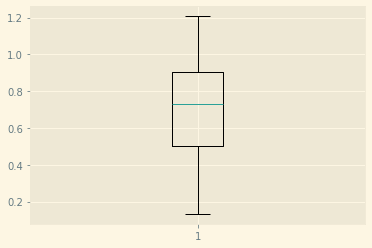

In [63]:
_ = plt.boxplot(lstm_errors)#, histtype='step')
# plt.ylabel('Frequence')
# plt.savefig("imgs/lstm_rnn_approx_error.pdf", bbox_inches='tight', dpi=900)

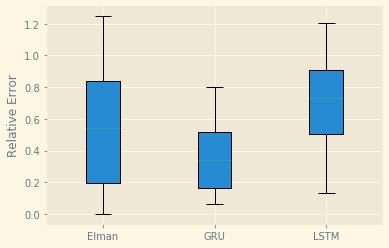

In [98]:
plt.style.use('Solarize_Light2')
_ = plt.boxplot([elman_errors, gru_errors, lstm_errors], patch_artist=True, labels=['Elman', 'GRU', 'LSTM'])
plt.ylabel('Relative Error')
plt.savefig("imgs/elman_gru_lstm_approx_error_sst.pdf", bbox_inches='tight', dpi=900)

## Explore Ngram Polarity Score

In [148]:
from nltk import ngrams
from collections import Counter
texts, labels = zip(*train_dg.data_batch)

In [149]:
texts[0][-3:]

[1092, 6889, 5]

In [150]:
n = 2
ngram_label_pair = []
ngram_set = []
for i, text in enumerate(texts):
    label = labels[i]
    if len(text)<n:
        continue
#     ###Find all possible ngrams
#     ngram_list = list(ngrams(text, n))
#     ngram_set += ngram_list
#     label_list = [label] * len(ngram_list)
#     ngram_label_pair += list(zip(ngram_list, label_list))
    
    ###Find the last ngrams
    ngram_list = text[-n:]
    ngram_set += [tuple(ngram_list)]
    ngram_label_pair += [(tuple(ngram_list), label)]
    
    

In [151]:
#ngram_label_pair

In [152]:
#get_phrase_polarity([16, 9, 39])

In [153]:
ngram_label_freq = Counter(ngram_label_pair)
ngram_set = set(ngram_set)
pos_ngram_scores = []
neg_ngram_scores = []
for item in ngram_set:
    item_pos = (item, 1)
    item_neg = (item, 0)
    diff = ngram_label_freq[item_pos] - ngram_label_freq[item_neg]
    sums = ngram_label_freq[item_pos] + ngram_label_freq[item_neg]
    rate = diff*1.0/sums
    if rate>0.8 and diff>3:
        #print(item, diff)
        phrase = list(item)
        #print(diff)
        ngram_score = get_phrase_polarity(phrase)
        pos_ngram_scores.append(ngram_score)
    if rate<-0.8 and diff<-3:
        phrase = list(item)
        #print(diff)
        ngram_score = get_phrase_polarity(phrase)
        neg_ngram_scores.append(ngram_score)


NameError: name 'get_phrase_polarity' is not defined

Text(0, 0.5, 'Freq Density')

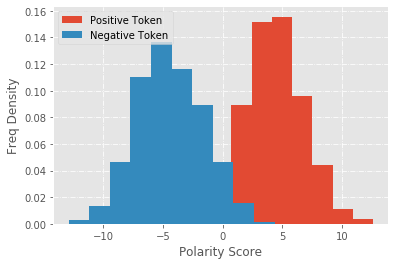

In [122]:
#pos_token_sentiment_score, neg_token_sentiment_score
plt.hist(pos_token_sentiment_score, label='Positive Token', density=True)
plt.hist(neg_token_sentiment_score, label='Negative Token', density=True)
plt.grid(linestyle='-.')
plt.legend()
plt.xlabel('Polarity Score')
plt.ylabel('Freq Density')
#plt.savefig("imgs/sst_token_polarity_score_gru.pdf", bbox_inches='tight', dpi=900)

In [96]:
#pos_ngram_scores

Text(0, 0.5, 'Freq Density')

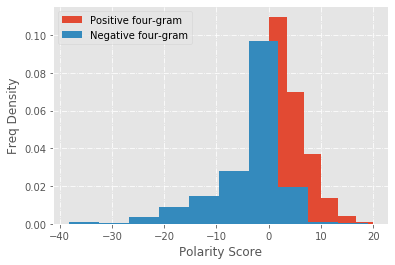

In [123]:
plt.hist(pos_ngram_scores, label='Positive four-gram', density=True)
plt.hist(neg_ngram_scores, label='Negative four-gram', density=True)
plt.grid(linestyle='-.')
plt.legend()
plt.xlabel('Polarity Score')
plt.ylabel('Freq Density')
#plt.savefig("imgs/sst_4gram_polarity_score_gru.pdf", bbox_inches='tight', dpi=900)

In [64]:
ngram = [16, 9, 39]
ngram_score = get_phrase_polarity(ngram)
ngram_score.item()

0.024874087423086166

## Statistics
Let us do an experiment, check whether the labels have strong relationship with certain words like the sentiment indicator "good", "bad"

In [45]:
texts, labels = zip(*train_dg.data_batch)
text_length = [len(t) for t in texts]

In [46]:
texts2, labels2 = zip(*dev_dg.data_batch)
text_length2 = [len(t) for t in texts2]

In [47]:
texts3, labels3 = zip(*test_dg.data_batch)
text_length3 = [len(t) for t in texts3]

In [48]:
#Calculate the times that a token appears in a specified label

In [49]:
word_label_pair = []
word_doc_freq = {}
vocab = []
for i, text in enumerate(texts):
    for w in text:
        word_doc_freq[w] = word_doc_freq.get(w, 0) + 1
        
for i, text in enumerate(texts):
    label = labels[i]
    for w in text:
        word_doc_freq[w] = word_doc_freq.get(w, 0) + 1
    word_label_pair += [(id2word[item], label) for item in text]
    vocab += [id2word[item] for item in text]
vocab = set(vocab)

In [51]:
word_label_pair_freq = Counter(word_label_pair)
#Get the ratio, a word appears in positive sentences: a word appears in negative sentences
token_freq_pos = {}
token_freq_neg = {}
type0_tokens = []
type1_tokens = []
type2_tokens = []
neutral_tokens = []
total_diff_freq = 0
#Note here, 1 means positive and 0 means negative
for w in vocab:
    freq_2 = word_label_pair_freq[(w, 2)]
    freq_1 = word_label_pair_freq[(w, 1)]
    freq_0 = word_label_pair_freq[(w, 0)]
    total = freq_1+freq_2+freq_0
    if total == 0:
        continue
    if freq_2/total>2/3:
        type2_tokens.append(w)
    if freq_1/total>2/3:
        type1_tokens.append(w)
    if freq_0/total>2/3:
        type0_tokens.append(w)


In [180]:
#print(neutral_tokens)

In [53]:
from textblob import TextBlob
pos_tokens_selected = []
neg_tokens_selected = []
for w in type2_tokens:
    s = TextBlob(w)
    if len(s.tags) == 0:
        continue
    if s.polarity>0.2 and s.tags[0][1]=='JJ':
        pos_tokens_selected.append(w)
for w in type0_tokens:
    s = TextBlob(w)
    if len(s.tags) == 0:
        continue
    if s.polarity<-0.2 and s.tags[0][1]=='JJ':
        neg_tokens_selected.append(w)        

In [56]:
# pos_tokens_index = [word2id[w] for w in pos_tokens]
# neg_tokens_index = [word2id[w] for w in neg_tokens]
# neutral_tokens_index = [word2id[w] for w in neutral_tokens]
# pos_tokens_index_label1 = [token_freq_pos[w] for w in pos_tokens_index]
# pos_tokens_index_label0 = [token_freq_neg[w] for w in pos_tokens_index]
# pos_tokens_index_diff = [token_freq_pos[w]-token_freq_neg[w] for w in pos_tokens_index]

# neg_tokens_index_label1 = [token_freq_pos[w] for w in pos_tokens_index]
# neg_tokens_index_label0 = [token_freq_neg[w] for w in pos_tokens_index]
# neg_tokens_index_diff = [token_freq_pos[w]-token_freq_neg[w] for w in neg_tokens_index]

## Visualization Negating Adjectives

In [78]:
hidden_dim = 300
pos_token_ps = []
negation_pos_token_ps = []
neg_token_ps = []
negation_neg_token_ps = []
negation_id = word2id['not']
for w in pos_tokens_selected:
    bigram = [negation_id] + [word2id[w]]
    score1 = gru_phrase_polarity_multi([word2id[w]], best_model, hidden_dim)
    score2 = gru_phrase_polarity_multi(bigram, best_model, hidden_dim)
    pos_token_ps.append(score1)
    negation_pos_token_ps.append(score2)
for w in neg_tokens_selected:
    bigram = [negation_id] + [word2id[w]]
    score1 = gru_phrase_polarity_multi([word2id[w]], best_model, hidden_dim)
    score2 = gru_phrase_polarity_multi(bigram, best_model, hidden_dim)
    neg_token_ps.append(score1)
    negation_neg_token_ps.append(score2)

In [79]:
pos_token_ps = torch.stack(pos_token_ps).detach().cpu().numpy()
neg_token_ps = torch.stack(neg_token_ps).detach().cpu().numpy()
negation_pos_token_ps = torch.stack(negation_pos_token_ps).detach().cpu().numpy()
negation_neg_token_ps = torch.stack(negation_neg_token_ps).detach().cpu().numpy()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f2c140eac10>,
 'caps': [<matplotlib.lines.Line2D at 0x7f2c140ebe50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f2c140ebe90>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2c140e8750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2c140e7910>,
 'means': []}

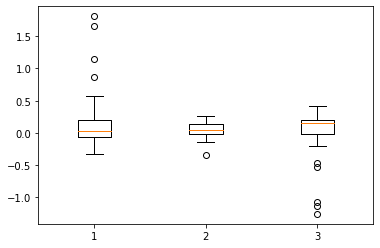

In [81]:
plt.boxplot([negation_neg_token_ps[:, 0], negation_neg_token_ps[:, 1], negation_neg_token_ps[:, 2]])

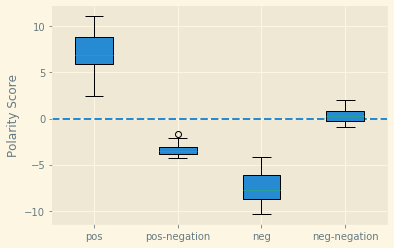

In [188]:
plt.style.use('Solarize_Light2')
_ = plt.boxplot([pos_token_ps, negation_pos_token_ps, neg_token_ps, negation_neg_token_ps], patch_artist=True, labels=['pos', 'pos-negation', 'neg', 'neg-negation'])
plt.ylabel('Polarity Score')
plt.plot([0.5, 4.5], [0, 0], linestyle='--')
# _ = plt.boxplot([pos_token_ps, negation_pos_token_ps], patch_artist=True)
#plt.savefig("imgs/mr_gru_polarity_score_negate_adjective.pdf", bbox_inches='tight', dpi=900)

## Visualizing Examples

In [93]:
hidden_dim = 300
# sent = "not to be dismissed".split()
# sent = "the movie is hardly a masterpiece".split()

sent = "hardly an objective documentary".split()
# sent = "never loses its ability to shock and amaze .".split()
# sent = "not always a narratively cohesive one .".split()
#sent = "hardly a film that comes along every day .".split()
# sent = "never achieve the popularity of my big fat greek wedding".split()
#sent = "never rises to its full potential as a film".split()
#sent = "never succeed in really rattling the viewer".split()
# sent = "hardly seems worth the effort .".split()
# sent = "does n t add up to much".split()
#sent = "hardly the most original fantasy film ever made".split()
#sent = "does n't wrap the proceedings up neatly".split()
#sent = "does n't completely survive its tonal transformation from dark comedy to suspense thriller".split()


sent = "never fails to fascinate".split()
# sent = 'hardly seems worth the effort'.split()
#sent = 'not in a good way'.split()
#sent = "what antwone fisher is n't , however , is original".split()
#sent = "however , is original".split()
#sent = "holds its goodwill close , but is relatively slow to come to the point".split()
#sent = "it 's never boring".split()
#sent = "same song , second verse , coulda been better , but it coulda been worse".split()
#sent = "want nothing else than to show us a good time".split()
#sent_example = 'this is possibly not horrible'.split()
lengths =  torch.LongTensor([len(sent)]).to(device)
sent_example = [word2id[w] for w in sent]

In [94]:
polarity_score = []
for i in range(len(sent_example)):
    temp = rnn_phrase_polarity_new(sent_example[i:], best_model, hidden_dim)
    polarity_score.append(temp)
polarity_score.reverse()

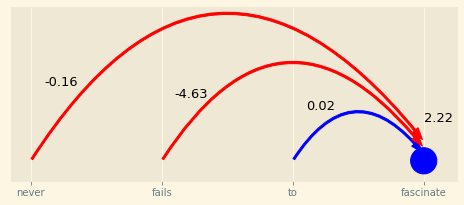

In [95]:
import matplotlib.patches as patches
index = len(sent)-1
temp = polarity_score#s[index]
#plt.style.use('ggplot')
plt.figure(figsize=(8, 3.2))
plt.xlim(-1, index+1) 
plt.ylim(0, 1.0) 
plt.xticks(range(index+1), sent, rotation=0) 

style = "Simple, tail_width=2, head_width=8, head_length=12"


for i in range(len(sent)):
#     if i == 1:
#         continue
#     if i == 3:
#         continue
    if temp[i]>0:
        kw = dict(arrowstyle=style, color="b")
    else:
        kw = dict(arrowstyle=style, color="r")
    a = patches.FancyArrowPatch((index-i, 0.1), (index, 0.1+0.05*i),
                                 connectionstyle="arc3,rad=-0.7", **kw)

    plt.gca().add_patch(a)
    if i == 0:
        plt.text(index-i, 0.4+0.09*i, s=str(round(temp[i], 2)), fontsize=13)
    else:
        plt.text(index-i+0.1, 0.4+0.09*i, s=str(round(temp[i], 2)), fontsize=13)
    
circle = plt.Circle((len(sent)-1, 0.1), 0.1, color='b')
plt.gca().add_patch(circle)
plt.axis('equal')

ax = plt.gca()
# ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
#plt.savefig("imgs/sst_gru_polarity_score_negation_example2_largefont.pdf", bbox_inches='tight', dpi=900)